In [6]:
import numpy as np
import numpy.random as npr
import numpy_financial as npf
import pandas as pd
%matplotlib inline
from pylab import mpl, plt
import seaborn as sns
mpl.style.use('seaborn')
mpl.rcParams['figure.figsize'] = (10, 6)

import\
    datetime as dt,\
    json,\
    requests,\
    threading,\
    time
import warnings
warnings.filterwarnings('ignore')

import panel as pn
pn.extension('plotly')
import plotly.express as px
import hvplot.pandas



from dotenv import find_dotenv, get_key

import quandl
quandl.ApiConfig.api_key = get_key(find_dotenv(), 'QUANDL_API_KEY')

API_KEY = get_key(find_dotenv(), 'ALPACA_API_KEY')
API_SECRET = get_key(find_dotenv(), 'ALPACA_SECRET_KEY')
APCA_API_BASE_URL = 'https://paper-api.alpaca.markets'
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame
api = REST(
    API_KEY,
    API_SECRET,
    api_version='v2',
)

In [24]:
feature = np.concatenate([np.array([1]), np.zeros([499])])
print(feature[:5])
print(feature.mean())
print(feature.std())
print(((feature - feature.mean()) / feature.std())[:5])

[1. 0. 0. 0. 0.]
0.002
0.044676615807377355
[22.3383079  -0.04476615 -0.04476615 -0.04476615 -0.04476615]


---

Alternative.me's Free Crypto API (https://alternative.me/crypto/api/)

In [18]:
BASE_URL = 'https://api.alternative.me/v2/'

def get_crypto_listing ():
    """
    From the website: Overview of all available crypto currencies,
    use the returned id to retrieve more data on a specific crypto currency on the ticker endpoint.
    """
    # pull json-formatted API data
    json_response = requests.get(f'{BASE_URL}listings/').json()
    
    df = pd.DataFrame(json_response['data'])
    
    df = df[[                # reorder columns
        'name',
        'symbol',
        'website_slug',
        'id',
    ]]
    df = df.rename(columns={ # rename columns
        'id': 'api_id',
    })
    
    return df, json_response['metadata']

def get_crypto_tickers ():
    """
    From the website: Coin and token prices updated every 5 minutes.
    """
    # pull json-formatted API data
    json_response = requests.get(f'{BASE_URL}ticker/?limit=0').json()
    
    df = pd.DataFrame(json_response['data'])
    df = df.T
    df = df.set_index(pd.RangeIndex(len(json_response['data'])))
    
    quotes_df = pd.json_normalize(df['quotes'])
    df = pd.concat([df, quotes_df], axis=1)
    
    df = df[[                               # reorder columns
        'name',
        'symbol',
        'rank',
        'USD.market_cap',
        'last_updated',
        'USD.price',
        'USD.volume_24h',
        'USD.percent_change_1h',
        'USD.percent_change_24h',
        'USD.percent_change_7d',
        'id',
    ]]
    df = df.rename(columns={                # rename columns
        'rank': 'market_cap_rank',
        'last_updated': 'last_updated_UTC',
        'id': 'api_id',
    })
    
    df['last_updated_UTC'] = pd.to_datetime(df['last_updated_UTC'], unit='s')
    
    return df, json_response['metadata']

def get_crypto_global ():
    """
    From the website: Get global market information at a glance.
    """
    # pull json-formatted API data
    json_response = requests.get(f'{BASE_URL}global/').json()
    
    df = pd.DataFrame(json_response['data'])
    df = df.set_index(pd.RangeIndex(1))
    
    quotes_df = pd.json_normalize(df['quotes'])
    df = pd.concat([df, quotes_df], axis=1)
    
    df = df[[                               # reorder columns
        'active_cryptocurrencies',
        'active_markets',
        'bitcoin_percentage_of_market_cap',
        'last_updated',
        'total_market_cap',
        'total_volume_24h',
    ]]
    df = df.rename(columns={                # rename columns
        'last_updated': 'last_updated_UTC',
    })
    
    df['last_updated_UTC'] = pd.to_datetime(df['last_updated_UTC'], unit='s')
    
    return df.T, json_response['metadata']

In [28]:
listings_df, listings_meta = get_crypto_listing()
listings_df.head()

,name,symbol,website_slug,api_id
0,Bitcoin,BTC,bitcoin,1
1,Litecoin,LTC,litecoin,2
2,Namecoin,NMC,namecoin,3
3,Terracoin,TRC,terracoin,4
4,Peercoin,PPC,peercoin,5


In [29]:
tickers_df, tickers_meta = get_crypto_tickers()
tickers_df.head()

,name,symbol,market_cap_rank,USD.market_cap,last_updated_UTC,USD.price,USD.volume_24h,USD.percent_change_1h,USD.percent_change_24h,USD.percent_change_7d,api_id
0,Bitcoin,BTC,1,937272048119,2021-05-14 01:59:08,50096.000000,86828738177,-0.249226,-0.392915,-11.346894,1
1,Ethereum,ETH,2,449470923144,2021-05-14 01:59:27,3872.520000,89755564212,1.254746,-3.463906,10.799448,1027
2,Binance Coin,BNB,3,90863926464,2021-05-14 01:59:58,587.060000,7017783890,1.191369,-4.927154,-7.628071,1839
3,Dogecoin,DOGE,4,62493586660,2021-05-14 01:59:02,0.482267,19816759861,0.382125,11.793540,-17.011904,74
4,XRP,XRP,5,62307495992,2021-05-14 01:58:43,1.350000,10678520159,-0.745434,0.678605,-15.565325,52


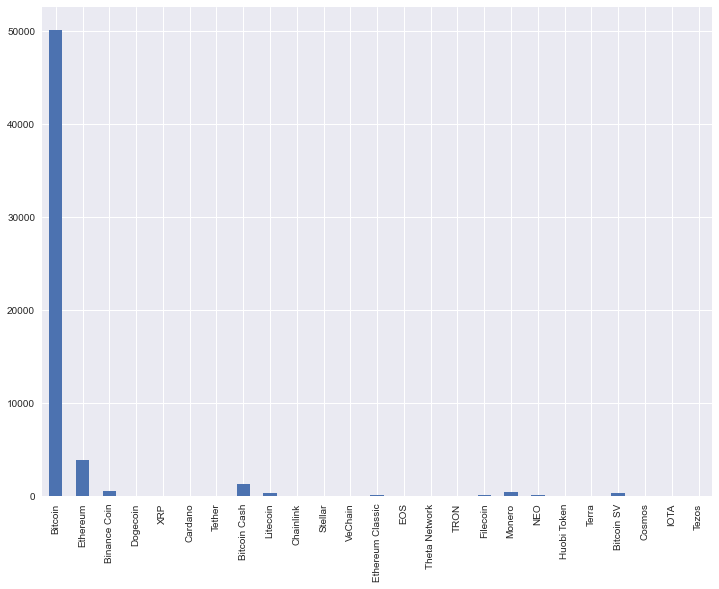

In [31]:
ax = tickers_df['USD.price'].head(25).plot.bar(figsize=(12, 9));
ax.set_xticklabels(tickers_df['name'].head(25));

---

Alpaca Markets Client SDK<br>
GitHub: https://github.com/alpacahq/alpaca-trade-api-python<br>
PyPI: https://pypi.org/project/alpaca-trade-api/<br>

In [116]:
def get_bars_sdk (symbol):
    df = alpaca.get_bars(
        symbol,
        TimeFrame.Day,
        '2021-04-01',
        '2021-04-01',
        limit=10_000,
    ).df
    df['symbol'] = symbol
    return df

# Alpaca Markets API
BASE_URL_HIST = 'https://data.alpaca.markets/v2/'
BASE_URL_PAPR = 'https://paper-api.alpaca.markets/v2/'
KEYS = {'APCA-API-KEY-ID': alpaca_api_key, 'APCA-API-SECRET-KEY': alpaca_secret_key,}

start = '2016-05-01'
end   = '2021-04-01'
today = pd.Timestamp(dt.date.today(), tz='America/New_York').isoformat()
now   = pd.Timestamp(dt.datetime.now(), tz='America/New_York').isoformat()
# (datetime.datetime(2016, 5, 1) - datetime.datetime(2021, 3, 1)).days / 365.25

def get_account ():
    json_response = requests.get(
        f'{BASE_URL_PAPR}account',
        headers=KEYS,
    ).json()
    return json_response
def create_order (symbol, qty, side, typ, time_in_force):
    data = {
        'symbol': symbol,
        'qty': qty,
        'side': side,
        'type': typ,
        'time_in_force': time_in_force,
    }
    json_response = requests.post(
        f'{BASE_URL_PAPR}orders',
        json=data,
        headers=KEYS,
    ).json()
    return json_response
#create_order('MSFT', 1000, 'buy', 'market', 'gtc')
def get_orders ():
    json_response = requests.get(
        f'{BASE_URL_PAPR}orders',
        headers=KEYS,
    ).json()
    return json_response


def get_historical_trades (symbol, start=start, end=end, limit=10_000):
    params = {
        'start': start,
        'end': now,
        'limit': limit,
    }
    json_response = requests.get(
        f'{BASE_URL_HIST}stocks/{symbol}/trades',
        params=params,
        headers=KEYS,
    ).json()
    return json_response

def get_historical_quotes (symbol, start=start, end=end, limit=10_000):
    """
    From the website: The quotes API provides NBBO quotes for a given ticker symbol at a specified date.
    """
    params = {
        'start': start,
        'end': now,
        'limit': limit,
    }
    json_response = requests.get(
        f'{BASE_URL_HIST}stocks/{symbol}/quotes',
        params=params,
        headers=KEYS,
    ).json()
    return json_response

def get_historical_bars (symbol='AAPL',
                         start=start,
                         end=now,
                         limit=10_000,
                         timeframe='1Day',
                         page_token=None):
    """
    The bars API returns aggregate historical data for the requested securities.
    """
    params = {
        'start': start,
        'end': end,
        'limit': limit,
        'timeframe': timeframe,
        'page_token': page_token,
    }
    json_response = requests.get(
        f'{BASE_URL_HIST}stocks/{symbol}/bars',
        params=params,
        headers=KEYS,
    ).json()
    
    df = pd.DataFrame.from_dict(json_response['bars']).rename(columns={
        't': 'Datetime',
        'o': 'Open Price',
        'h': 'High Price',
        'l': 'Low Price',
        'c': 'Close Price',
        'v': 'Volume',
    })
    df = df.set_index('Datetime')
    df.index = pd.DatetimeIndex(df.index)
    
    df = df.set_index(
        pd.MultiIndex.from_arrays(
            [df.index.year, df.index.month, df.index.day],
            names=['year', 'month', 'day']
        )
    )
    #df = df.groupby([df.index.year, df.index.month, df.index.day]).first()
    
    return df

def get_assets ():
    json_response = requests.get(f'{BASE_URL_PAPR}assets', headers=KEYS).json()
    df = pd.DataFrame(json_response)
    return df

In [133]:
df = get_assets()
df

,id,class,exchange,symbol,name,status,tradable,marginable,shortable,easy_to_borrow,fractionable
0,fd7ecda8-13ff-43e3-81cd-50a95a5f3bc9,us_equity,NYSE,ABG,"Asbury Automotive Group, Inc.",active,True,True,True,True,False
1,29f8c27e-3284-4f6d-8f56-9713b020ecdc,us_equity,NYSE,ACV,Virtus AllianzGI Diversified Income & Converti...,active,True,True,True,True,False
2,2f6c684e-6f06-4db7-8776-bac9a7093601,us_equity,NASDAQ,ACWI,iShares MSCI ACWI ETF,active,True,True,True,True,True
3,8ece6223-c699-4d88-b50f-4170ed6fd724,us_equity,NASDAQ,ADMA,ADMA Biologics Inc Common Stock,active,True,True,True,True,False
4,1099a725-d87f-4e76-916c-2121e03bd592,us_equity,NASDAQ,ADUS,Addus HomeCare Corporation Common Stock,active,True,True,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...
11754,ef9adcc6-6bce-452b-af5f-4a87e7f19131,us_equity,NYSE,JNJ,Johnson & Johnson,active,True,True,True,True,True
11755,6c20a838-99dc-48d7-a907-90d8b69759b2,us_equity,NASDAQ,KCAPL,"KCAP Financial, Inc. 6.125% Notes due 2022",active,True,True,False,False,False
11756,75c9e191-bf26-4eed-891a-b9c862189c96,us_equity,NASDAQ,MBIN,Merchants Bancorp Common Stock,active,True,True,True,True,False
11757,abc8f93b-8f15-4018-b86a-c98b2d1dca4c,us_equity,NASDAQ,MDIA,Mediaco Holding Inc. Class A Common Stock,active,True,True,False,False,False


---

# Long-Short Equity

This trading algorithm implements the long-short equity strategy. This means that the algorithm will rank a given universe of stocks based on a certain metric, and long the top ranked stocks and short the lower ranked stocks. More specifically, the algorithm uses the frequently used 130/30 percent equity split between longs and shorts (130% of equity used for longs, 30% of equity used for shorts). The algorithm will then grab the top and bottom 25% of stocks, and long or short them accordingly. The algorithm will purchase equal quantities across a bucket of stocks, so all stocks in the long bucket are ordered with the same quantity (same with the short bucket). After every minute, the algorithm will re-rank the stocks and make adjustments to the position if necessary. For more information on this strategy, read this link here https://www.investopedia.com/terms/l/long-shortequity.asp.

Some stocks cannot be shorted. In this case, the algorithm uses the leftover equity from the stocks that could not be shorted and shorts the stocks have already been shorted.

The algorithm uses percent change in stock price over the past 10 minutes to rank the stocks, where the stocks that rose the most are longed and the ones that sunk the most are shorted.

In [5]:
class LongShort:
    def __init__ (self):
        self.alpaca = tradeapi.REST(API_KEY, API_SECRET, APCA_API_BASE_URL, 'v2')
        
        stockUniverse = ['DOMO', 'TLRY', 'SQ', 'MRO', 'AAPL', 'GM', 'SNAP', 'SHOP',
                     'SPLK', 'BA', 'AMZN', 'SUI', 'SUN', 'TSLA', 'CGC', 'SPWR',
                     'NIO', 'CAT', 'MSFT', 'PANW', 'OKTA', 'TWTR', 'TM', 'RTN',
                     'ATVI', 'GS', 'BAC', 'MS', 'TWLO', 'QCOM']
        self.allStocks = []
        for stock in stockUniverse:
            self.allStocks.append([stock, 0])
            
        self.long = []
        self.short = []
        self.qShort = None
        self.qLong = None
        self.adjustedQLong = None
        self.adjustedQShort = None
        self.blacklist = set()
        self.longAmount = 0
        self.shortAmount = 0
        self.timeToClose = None
        
    def run (self):
        # First, cancel any existing orders so they don't impact our buying power.
        orders = self.alpaca.list_orders(status='open')
        for order in orders:
            self.alpaca.cancel_order(order.id)
            
        # Wait for the market to open.
        print('Waiting for the market to open...')
        tAMO = threading.Thread(target=self.awaitMarketOpen)
        tAMO.start()
        tAMO.join()
        print('Market opened.')
        
        # Rebalance the portfolio every minute, making necessary trades.
        while True:
            # Figure out when the market will close so we can prepare to sell beforehand.
            clock = self.alpaca.get_clock()
            closingTime = clock.next_close.replace(tzinfo=dt.timezone.utc).timestamp()
            currTime = clock.timestamp.replace(tzinfo=dt.timezone.utc).timestamp()
            self.timeToClose = closingTime - currTime
            
            if (self.timeToClose < (60 * 15)):
                # Close all positions when 15 minutes til market close.
                print('Market closing soon. Closing positions.')
                
                positions = self.alpaca.list_positions()
                for position in positions:
                    if (position.side == 'long'):
                        orderSide = 'sell'
                    else:
                        orderSide = 'buy'
                    qty = abs(int(float(position.qty)))
                    respS0 = []
                    tSubmitOrder = threading.Thread(target=self.submitOrder(qty, position.symbol, orderSide, respS0))
                    tSubmitOrder.start()
                    tSubmitOrder.join()
                    
                # Run the script again after the market close for next trading day.
                print('Sleeping until market close (15 minutes).')
                time.sleep(60 * 15)
            else:
                # Rebalance the portfolio.
                tRebalance = threading.Thread(target=self.rebalance)
                tRebalance.start()
                tRebalance.join()
                time.sleep(60)
                
    # Wait for the market to open.
    def awaitMarketOpen (self):
        isOpen = self.alpaca.get_clock().is_open
        while (not isOpen):
            clock = self.alpaca.get_clock()
            openingTime = clock.next_open.replace(tzinfo=dt.timezone.utc).timestamp()
            currTime = clock.timestamp.replace(tzinfo=dt.timezone.utc).timestamp()
            timeToOpen = int((openingTime - currTime) / 60)
            print(str(timeToOpen) + ' minutes til market open.')
            time.sleep(60)
            isOpen = self.alpaca.get_clock().is_open
            
    def rebalance (self):
        tRerank = threading.Thread(target=self.rerank)
        tRerank.start()
        tRerank.join()
        
        # Clear existing orders again.
        orders = self.alpaca.list_orders(status='open')
        for order in orders:
            self.alpaca.cancel_order(order.id)
            
        print('We are taking a long position in: ' + str(self.long))
        print('We are taking a short position in: ' + str(self.short))
        # Remove positions that are no longer in the short or long list,
        # and make a list of positions that do not need to change.
        # Adjust position quantities if needed.
        executed = [[], []]
        positions = self.alpaca.list_positions()
        self.blacklist.clear()
        for position in positions:
            if (self.long.count(position.symbol) == 0):
                # Position is not in long list.
                if (self.short.count(position.symbol) == 0):
                    # Position not in short list either. Clear position.
                    if (position.side == 'long'):
                        side = 'sell'
                    else:
                        side = 'buy'
                    respS0 = []
                    tS0 = threading.Thread(target=self.submitOrder, args=[abs(int(float(position.qty))), position.symbol, side, respS0])
                    tS0.start()
                    tS0.join()
                else:
                    # Position in short list.
                    if (position.side == 'long'):
                        # Position changed from long to short. Clear long position to prepare for short position.
                        side = 'sell'
                        respS0 = []
                        tS0 = threading.Thread(target=self.submitOrder, args=[int(float(position.qty)), position.symbol, side, respS0])
                        tS0.start()
                        tS0.join()
                    else:
                        if (abs(int(float(position.qty))) == self.qShort):
                            # Position is where we want it. Pass for now.
                            pass
                        else:
                            # Need to adjust position amount
                            diff = abs(int(float(position.qty))) - self.qShort
                            if (diff > 0):
                                # Too many short positions. Buy some back to rebalance.
                                side = 'buy'
                            else:
                                # Too little short positions. Sell some more.
                                side = 'sell'
                            respS0 = []
                            tS0 = threading.Thread(target=self.submitOrder, args=[abs(diff), position.symbol, side, respS0])
                            tS0.start()
                            tS0.join()
                        executed[1].append(position.symbol)
                        self.blacklist.add(position.symbol)
            else:
                # Position in long list.
                if (position.side == 'short'):
                    # Position changed from short to long. Clear short position to preapre for long position.
                    respS0 = []
                    tS0 = threading.Thread(target=self.submitOrder, args=[abs(int(float(position.qty))), position.symbol, 'buy', respS0])
                    tS0.start()
                    tS0.join()
                else:
                    if (int(float(position.qty)) == self.qLong):
                        # Position is where we want it. Pass for now.
                        pass
                    else:
                        # Need to adjust position amount.
                        diff = abs(int(float(position.qty))) - self.qLong
                        if (diff > 0):
                            # Too many long positions. Sell some to rebalance.
                            side = 'sell'
                        else:
                            # Too little long positions. Buy some more.
                            side = 'buy'
                        respS0 = []
                        tS0 = threading.Thread(target=self.submitOrder, args=[abs(diff), position.symbol, side, respS0])
                        tS0.start()
                        tS0.join()
                    executed[0].append(position.symbol)
                    self.blacklist.add(position.symbol)
                    
        # Send orders to all remaining stocks in the long and short list.
        respSendBOLong = []
        tSendBOLong = threading.Thread(target=self.sendBatchOrder, args=[self.qLong, self.long, 'buy', respSendBOLong])
        tSendBOLong.start()
        tSendBOLong.join()
        respSendBOLong[0][0] += executed[0]
        if (len(respSendBOLong[0][1]) > 0):
            # Handle rejected/incomplete orders and determine new quantities to purchase.
            respGetTPLong = []
            tGetTPLong = threading.Thread(target=self.getTotalPrice, args=[respSendBOLong[0][0], respGetTPLong])
            tGetTPLong.start()
            tGetTPLong.join()
            if (respGetTPLong[0] > 0):
                self.adjustedQLong = self.longAmount // respGetTPLong[0]
            else:
                self.adjustedQLong = -1
        else:
            self.adjustedQLong = -1
            
        respSendBOShort = []
        tSendBOShort = threading.Thread(target=self.sendBatchOrder, args=[self.qShort, self.short, 'sell', respSendBOShort])
        tSendBOShort.start()
        tSendBOShort.join()
        respSendBOShort[0][0] += executed[1]
        if (len(respSendBOShort[0][1]) > 0):
            # Handle rejected/incomplete orders and determine new quantities to purchase.
            respGetTPShort = []
            tGetTPShort = threading.Thread(target=self.getTotalPrice, args=[respSendBOShort[0][0], respGetTPShort])
            tGetTPShort.start()
            tGetTPShort.join()
            if (respGetTPShort[0] > 0):
                self.adjustedQShort = self.shortAmount // respGetTPShort[0]
            else:
                self.adjustedQShort = -1
        else:
            self.adjustedQShort = -1
            
        # Reorder stocks that didn't throw an error so that the equity quota is reached.
        if (self.adjustedQLong > -1):
            self.qLong = int(self.adjustedQLong - self.qLong)
            for stock in respSendBOLong[0][0]:
                respResendBOLong = []
                tResendBOLong = threading.Thread(target=self.submitOrder, args=[self.qLong, stock, 'buy', respResendBOLong])
                tResendBOLong.start()
                tResendBOLong.join()
                
        if (self.adjustedQShort > -1):
            self.qShort = int(self.adjustedQShort - self.qShort)
            for stock in respSendBOShort[0][0]:
                respResendBOShort = []
                tResendBOShort = threading.Thread(target=self.submitOrder, args=[self.qShort, stock, 'sell', respResendBOShort])
                tResendBOShort.start()
                tResendBOShort.join()
                
    # Re-rank all stocks to adjust longs and shorts.
    def rerank (self):
        tRank = threading.Thread(target=self.rank)
        tRank.start()
        tRank.join()
        
        # Grabs the top and bottom quarter of the sorted stock list to get the long and short lists.
        longShortAmount = len(self.allStocks) // 4
        self.long = []
        self.short = []
        for i, stockField in enumerate(self.allStocks):
            if (i < longShortAmount):
                self.short.append(stockField[0])
            elif (i > (len(self.allStocks) - 1 - longShortAmount)):
                self.long.append(stockField[0])
            else:
                continue
                
        # Determine amount to long/short based on total stock price of each bucket.
        equity = int(float(self.alpaca.get_account().equity))
        
        self.shortAmount = equity * 0.30
        self.longAmount = equity - self.shortAmount
        
        respGetTPLong = []
        tGetTPLong = threading.Thread(target=self.getTotalPrice, args=[self.long, respGetTPLong])
        tGetTPLong.start()
        tGetTPLong.join()
        
        respGetTPShort = []
        tGetTPShort = threading.Thread(target=self.getTotalPrice, args=[self.short, respGetTPShort])
        tGetTPShort.start()
        tGetTPShort.join()
        
        self.qLong = int(self.longAmount // respGetTPLong[0])
        self.qShort = int(self.shortAmount // respGetTPShort[0])
        
    # Get the total price of the array of input stocks.
    def getTotalPrice (self, stocks, resp):
        totalprice = 0
        for stock in stocks:
            bars = self.alpaca.get_bars(stock, TimeFrame.Minute,
                                       pd.Timestamp('now').date(),
                                       pd.Timestamp('now').date(), limit=1,
                                       adjustment='raw')
            totalPrice += bars[stock][0].c
        resp.append(totalPrice)
        
    # Submit a batch order that returns completed and uncompleted orders.
    def sendBatchOrder (self, qty, stocks, side, resp):
        executed = []
        incomplete = []
        for stock in stocks:
            if (self.blacklist.isdisjoint({stock})):
                respS0 = []
                tSubmitOrder = threading.Thread(target=self.submitOrder, args=[qty, stock, side, respS0])
                tSubmitOrder.start()
                tSubmitOrder.join()
                if (not respS0[0]):
                    # Stock order did not go through, add it to incomplete.
                    incomplete.append(stock)
                else:
                    executed.append(stock)
                respS0.clear()
        resp.append([executed, incomplete])
        
    # Submit an order if quantity is above 0.
    def submitOrder (self, qty, stock, side, resp):
        if (qty > 0):
            try:
                self.alpaca.submit_order(stock, qty, side, 'market', 'day')
                print('Market order of | ' + str(qty) + ' ' + stock + ' ' + side + ' | completed.')
                resp.append(True)
            except:
                print('Order of | ' + str(qty) + ' ' + stock + ' ' + side + ' | did not go through.')
                resp.append(False)
        else:
            print('Quantity is 0, order of | ' + str(qty) + ' ' + stock + ' ' + side + ' | not completed.')
            resp.append(True)
            
    # Get percent changes of the stock prices over the past 10 minutes.
    def getPercentChanges (self):
        length = 10
        for i, stock in enumerate(self.allStocks):
            bars = self.alpaca.get_bars(stock[0], TimeFrame.Minute,
                                       pd.Timestamp('now').date(),
                                       pd.Timestamp('now').date(), limit=length,
                                       adjustment='raw')
            self.allStocks[i][1] = (bars[stock[0]][len(bars[stock[0]]) - 1].c - bars[stock[0]][0].o) / bars[stock[0]][0].o
            
    # Mechanism used to rank the stocks, the basis of the Long-Short Equity Strategy.
    def rank (self):
        # Ranks all stocks by percent change over the past 10 minutes (higher is better).
        tGetPC = threading.Thread(target=self.getPercentChanges)
        tGetPC.start()
        tGetPC.join()
        
        # Sort the stocks in place by the percent change field (marked by pc).
        self.allStocks.sort(key=lambda x: x[1])
        
# Run the LongShort class
ls = LongShort()
ls.run()

Waiting for the market to open...
3717 minutes til market open.


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 597, in urlopen
    httplib_response = self._make_request(conn, method, url,
  File "/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 384, in _make_request
    six.raise_from(e, None)
  File "<string>", line 2, in raise_from
  File "/opt/anaconda3/lib/python3.8/site-packages/urllib3/connectionpool.py", line 380, in _make_request
    httplib_response = conn.getresponse()
  File "/opt/anaconda3/lib/python3.8/http/client.py", line 1322, in getresponse
    response.begin()
  File "/opt/anaconda3/lib/python3.8/http/client.py", line 303, in begin
    version, status, reason = self._read_status()
  File "/opt/anaconda3/lib/python3.8/http/client.py", line 272, in _read_status
    raise RemoteDisconnected("Remote end closed connection without"
http.client.RemoteDisconnected: Remote end closed connection without response



Market opened.


Exception in thread Thread-9:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/opt/anaconda3/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-5-49771a317126>", line 312, in getPercentChanges
TypeError: list indices must be integers or slices, not str
Exception in thread Thread-10:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/opt/anaconda3/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-5-49771a317126>", line 269, in getTotalPrice
UnboundLocalError: local variable 'totalPrice' referenced before assignment
Exception in thread Thread-11:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File

We are taking a long position in: ['RTN', 'ATVI', 'GS', 'BAC', 'MS', 'TWLO', 'QCOM']
We are taking a short position in: ['DOMO', 'TLRY', 'SQ', 'MRO', 'AAPL', 'GM', 'SNAP']
Market order of | 1000 MSFT sell | completed.
Market order of | 200 AAPL sell | completed.


ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

---